# HW02: StackOverFlow. Predicción de nuevpas preguntas Matlab.
## PAblo Soto López. MCD Cunef.
Introducción

¿Podríamos vivir sin StackOverFlow?

En el fichero StackOverflow.csv, se encuentran datos sobre el número de nuevas preguntas que se realizan mensualmente para los diferentes lenguajes de
programación.

Nos interesa analizar la evolución de las preguntas sobre MATLAB y construir
un modelo predictivo de series temporales.

**Trabajo a realizar**

 * Analizar los datos de MATLAB, entre otros análisis, se debe graficar la
serie, estudiar la estacionalidad y la estacionariedad.

* Se debe separa la muestra en tres partes entrenamiento, validación(12
meses) y test(6meses).Cuando no sea necesaria la validación la muestra
de test debe ser de 6 meses.

* Debemos buscar el mejor modelo predictivo entre los siguientes:
1. ETS
2. ARIMA
3. 4Theta
4. TBATS


* Una vez seleccionado el modelo se debe realizar una predicción de 12
meses fuera de la muestra.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import os, sys
#from google.colab import drive

from sktime.utils.plotting import plot_correlations
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from pmdarima.arima import ADFTest, ndiffs
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.arima import AutoARIMA

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rc("font", size=14)
import seaborn as sns

from darts.utils.statistics import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from datetime import datetime

import darts
from darts import TimeSeries
from darts.models import FourTheta
from darts.metrics import mape, rmse
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import TBATS

In [2]:
# Leemos los datos de la serie temporal de Drive.

from pandas.tseries.offsets import DateOffset
stack_df = pd.read_csv('StackOverflow.csv',sep=',' ,usecols=['month','matlab'])
stack_df['month'] = pd.to_datetime(stack_df['month'],format="%y-%b")

In [3]:
# >Pasamos month a index.
stack_df = stack_df.set_index('month')

# Necesario para trabajar con darts timeseries, que tenga el indice tenga frecuencia asignada.
stack_df.index.freq = 'MS'
# CComprobamos frecuencia indice.
stack_df.index.freq

<MonthBegin>

In [4]:
# Serie en formato sktime, con periodindex.
stack_ts_m= stack_df['matlab'].astype('float64').to_period('m').sort_index()
stack_ts_m.tail()

month
2019-08    371.0
2019-09    362.0
2019-10    523.0
2019-11    479.0
2019-12    349.0
Freq: M, Name: matlab, dtype: float64

# Matlab. Lenguaje programación muy académico.

MATLAB (abreviatura de MATrix LABoratory, «laboratorio de matrices») es un sistema de cómputo numérico que ofrece un entorno de desarrollo integrado (IDE) con un lenguaje de programación propio (lenguaje M). 

Se comenzó a desarrollar en los años 70, cointinua su desarrollo hasta la actualidad.
Es un software muy usado en universidades y centros de investigación y desarrollo.

Durante mucho tiempo hubo críticas porque MATLAB es un producto propietario de The Mathworks, y los usuarios están sujetos y bloqueados al vendedor. 

Para poder usarlo hay que pagar una licencia, cuyos precios va desde los 840 € por una licencia standar, hasta los 30 € por curso para un estudiante de grado, en la actualidad.

Existe una alternativa en software libre con el mismo proposito, Octave, lanzado a mitad de los años 90. Implementado por la comunidad cientifica como respuesta al dominio de Matlab.

Fuentes: Wikipedia y web comercial Matlb.


## Estudio gráfico de estacionariedad, tendencia  y estacionalidad.

#### **Tendencia:**

Presenta una tendiencia no lineal.
En todos los estudios gráficos se observa una clara tendencia creciente de 2.009 hasta 2.015, tranformandose en un calara tendencia negativa en los últimos 4 años de la serie.  El máximo de consultas se produce en el segundo trimestre de 2.015. Parece que a partir de ese momento entra en declive, la comunidad de programdores genera menos consultas sobre este lenguaje.


#### **Estacionalidad:**

Presenta una estacionalidad compleja, repitiendose todos los años lo que parecen dos ciclos, diferenciados. Un ciclo de gran actividad entre los 4 y cinco primeros meses de cada año, descender hasta mínimos hasta sptiembre, terminando con un leve repunte en los últimos trimestres de cada año. Estos ciclos parecen reproducir un callendario academico, desde principio de año, creciente actividad de enero a mayo, bajada de actividad en el verano, vuelta al trabajo a la altura del último trimestre del año, con parón en navidades.

#### **Errores**:

Aplicando el modelo de descomposición aditivo los errores parecen tener cierto patrón de U invertida dentro de cada año, se suaviza mucho aplicando el método multiplicativo de descomposición.

#### **Estacionariedad**:

Ya en las visualizaciones, se oberva que la serie tiene tendencia y estacionalidad, lo que nos indica que es UNA SERIE NO ESTACIONARIA. Aplicando el test de Dickey-Fuller aumentado nos confirma la NO ESTACIONARIEDAD de la serie.










(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='matlab'>)

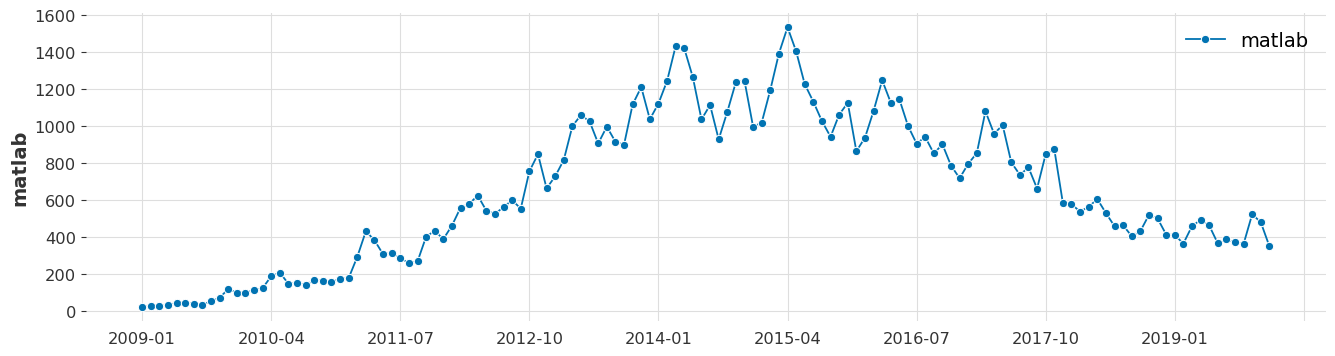

In [5]:
plot_series(stack_ts_m, labels=["matlab"])

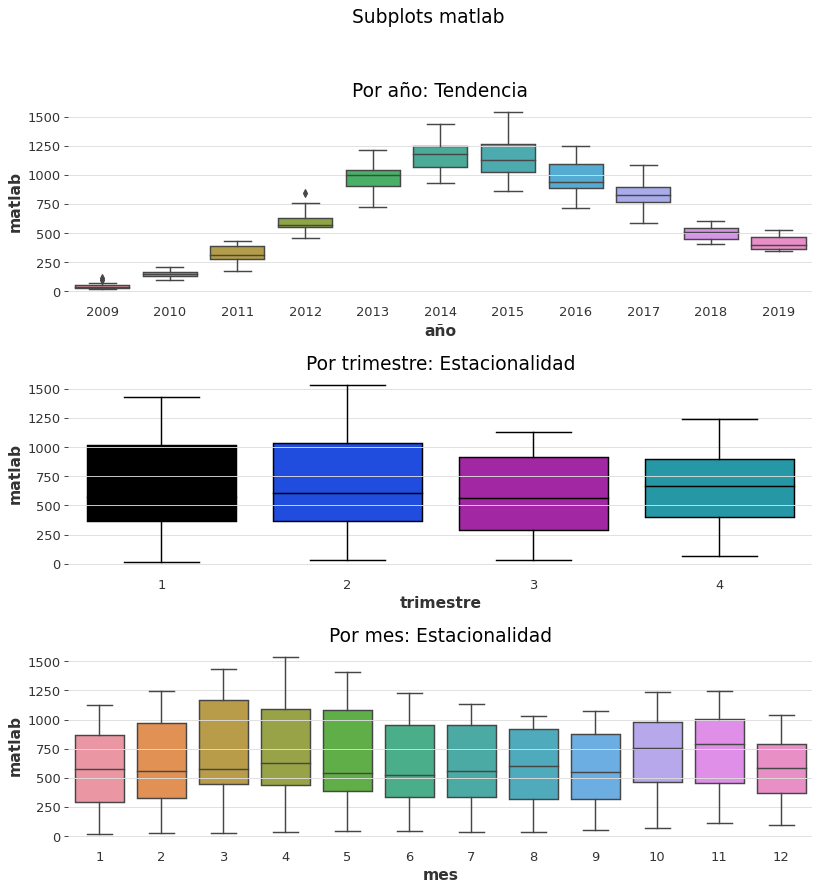

In [6]:
# Box-plot con tres escalas temporales.
fig, (axes1, axes2,axes3) = plt.subplots(3, 1, figsize=(12,12), dpi= 80)
sns.boxplot(x=stack_df.index.year, y=stack_df['matlab'], data=stack_df, ax=axes1)
sns.boxplot(x=stack_df.index.quarter, y=stack_df['matlab'], data=stack_df, ax=axes2)
sns.boxplot(x=stack_df.index.month, y=stack_df['matlab'], data=stack_df, ax=axes3)
fig.suptitle('Subplots matlab')
axes1.set_title('Por año: Tendencia')
axes2.set_title('Por trimestre: Estacionalidad')
axes3.set_title('Por mes: Estacionalidad')
axes1.set_xlabel("año")
axes2.set_xlabel("trimestre")
axes3.set_xlabel("mes")
fig.subplots_adjust(hspace=.4)

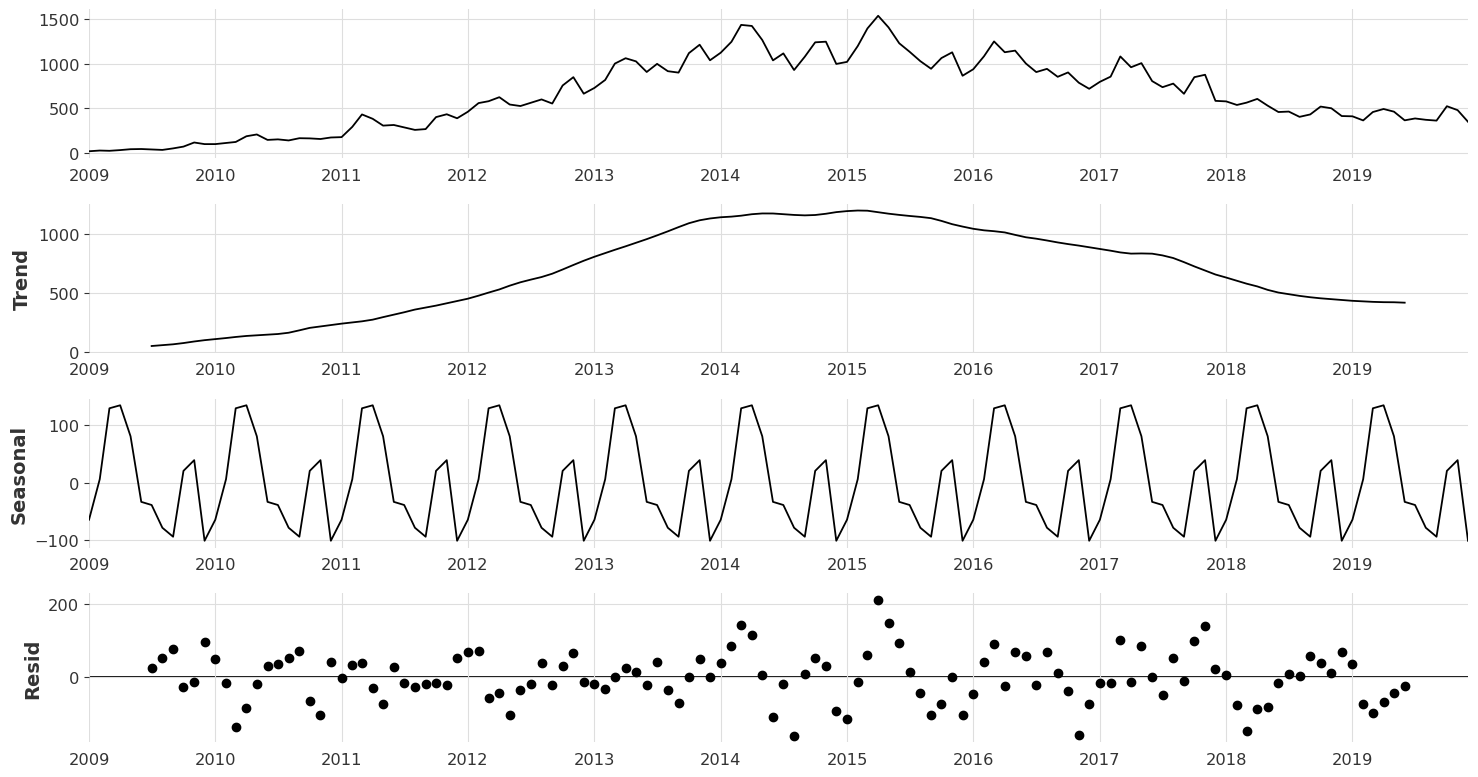

In [7]:
# Descomposición modelo aditivo.
res = seasonal_decompose(stack_df, model='aditive')
fig = res.plot()
fig.set_size_inches((15, 8))
# Tight layout to realign things
fig.tight_layout()
plt.show()


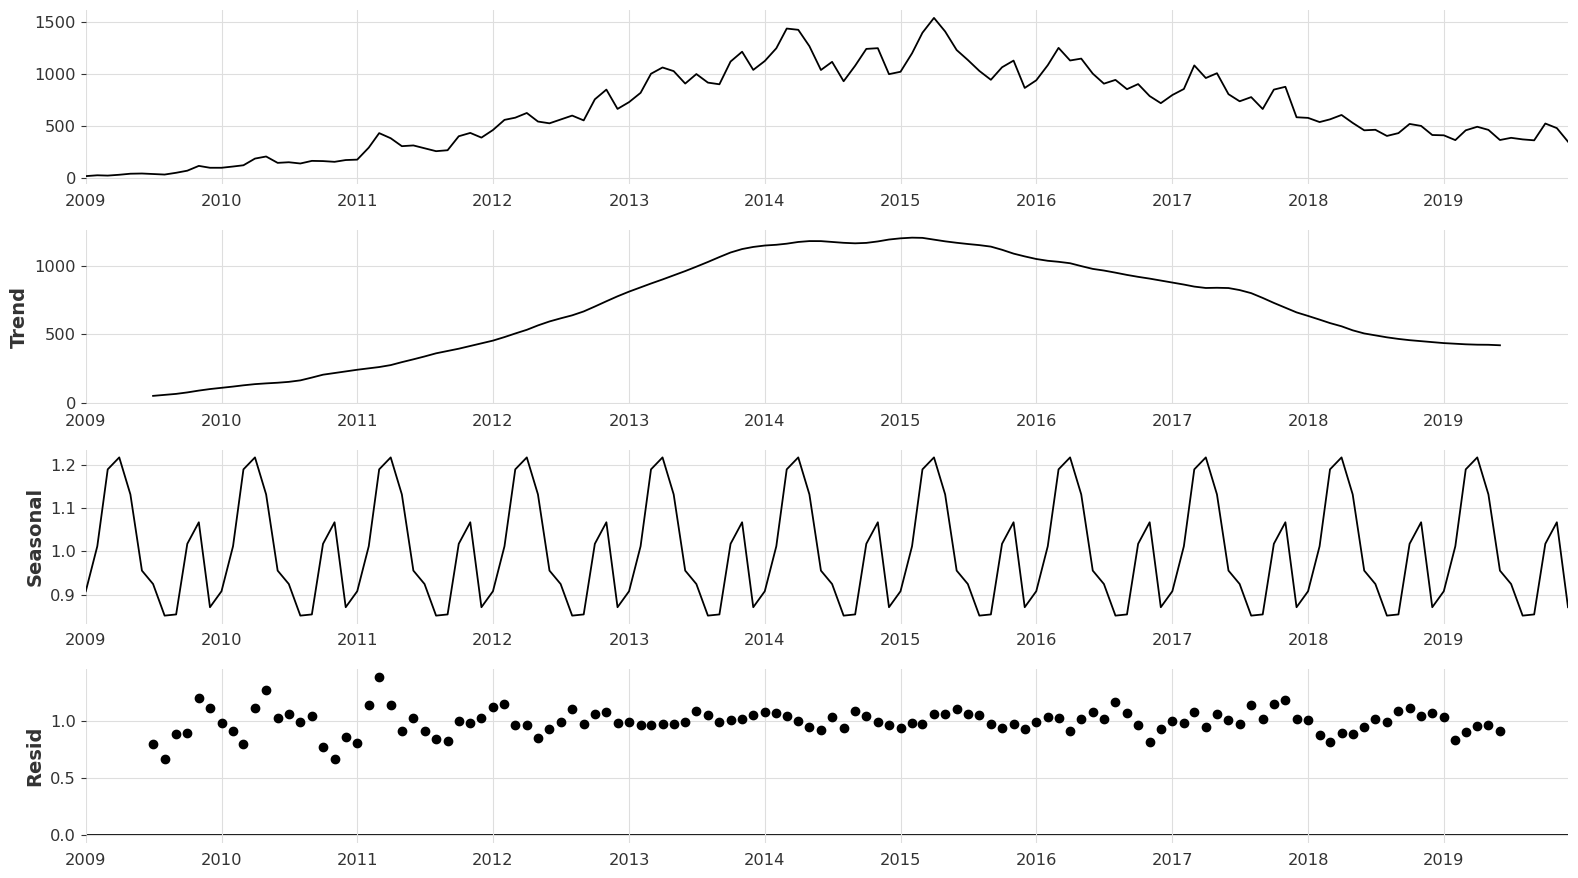

In [8]:
# Descomposición modelo multiplicativo.
res = seasonal_decompose(stack_df, model='multiplicative')
fig = res.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()


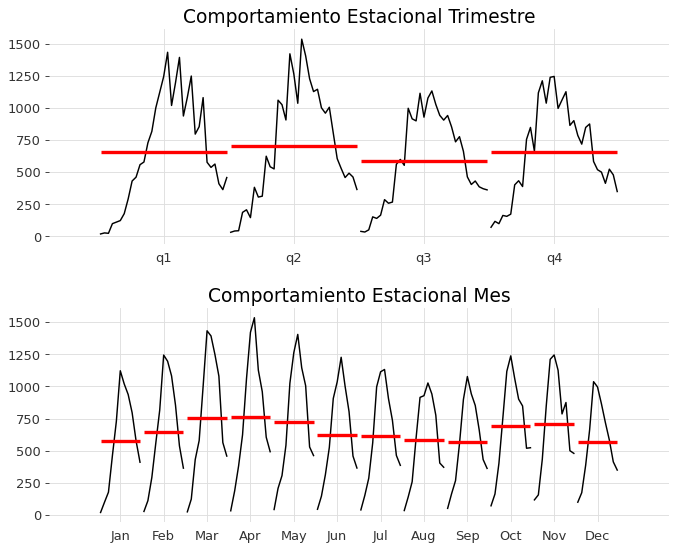

In [9]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), dpi= 80)

sm.graphics.tsa.quarter_plot(stack_df.to_period('q').sort_index(),ax=ax1)
ax1.set_title('Comportamiento Estacional Trimestre')
sm.graphics.tsa.month_plot(stack_df.resample("m").sum(),ax=ax2)
ax2.set_title('Comportamiento Estacional Mes')
fig.subplots_adjust(hspace=.3)

In [10]:
 # Tes de estacionalidad arededor de una tendiencia: regression = 'ct'

result_ad = adfuller(stack_df['matlab'], autolag='AIC', regression = 'ct')
print(f'ADF Statistic: {result_ad[0]}')
print(f'p-value: {result_ad[1]}')
print(f'Resulados ADF:  La sesie es {"no " if result_ad[1] > 0.05 else ""} estacionaria.')

ADF Statistic: -1.1866406869792103
p-value: 0.9132045761107735
Resulados ADF:  La sesie es no  estacionaria.


### División Train - Validation - Test.

Para los modelos ETS y ARIMA vamos a utilizar las funciones de de sktime AutoETS y Autoarima, de manera que determinarimos el mejor modelo sin conjunto de test.
Es decir, dejaremos los último 6 meses paara probar la calidad del ajsute.

Para el modelo Bats utilizaremos la validation de 12 meses para encontrar el mejor modelo. Dejando los últimos 6 meses para controlar la calidad del ajuste.

En cuanto al modelo BATS, dado que poniendo paramtros a None, en el proceso de ajuste del modelo elige las mejores opciones. Vamos reservar solo los últimos 6 meses para test.



### MODELO ETS.
Ulilizamos la función autoETS de sktime, permitiendo tendiencia multiplicativa, y suponiendo ciclos estacionales trimestrales. 

AutoETS nos selecciona un modelo multiplicativo para todos los términos con tendiencia suavizada.

En la visualización de las predicciones se observa que llega a ajustar las dirección pero infravalora los movimientos. Quizas el modelo no es capaz de lidiar con las estacionalidad compleja que tiene esta serie.



In [11]:
# Dividimos en trsin y test, segun las especificaciones del caso.
y_train, y_test = temporal_train_test_split(y =stack_ts_m, 
                                            test_size=6)

126 6


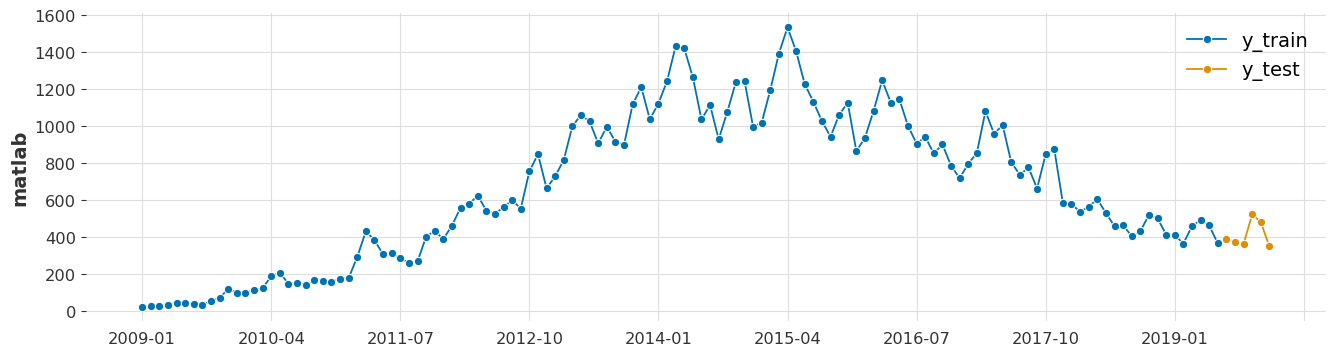

In [12]:
# Comprobamos división.
plot_series(y_train, y_test, labels=["y_train", "y_test"])
# Visualizamos tamaño de los datasets.
print(y_train.shape[0], y_test.shape[0])

In [13]:
# Tipificamos horizonte de predicción: 6 de test.
fh_test = np.arange(1,7)

In [14]:
# Buscamos el mejor modelo ETS.
stack_autoets = AutoETS( auto=True, 
                          sp=4,
                          allow_multiplicative_trend=True,
                          information_criterion='aic',
                          n_jobs=-1)

In [15]:
# Ajustamos el modelo a los datos de entrenamiento
stack_autoets.fit(y_train)

AutoETS(allow_multiplicative_trend=True, auto=True, n_jobs=-1, sp=4)

In [16]:
# Sumario
stack_autoets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                 matlab   No. Observations:                  126
Model:                      ETS(MMdM)   Log Likelihood                -720.606
Date:                Tue, 22 Nov 2022   AIC                           1463.211
Time:                        11:13:15   BIC                           1494.410
Sample:                    01-31-2009   HQIC                          1475.886
                         - 06-30-2019   Scale                            0.023
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.098     10.188      0.000       0.808       1.192
smoothing_trend     9.999e-05      0.115      0.001      0.999      -0.225       0.225
smoothing_seasonal  2.663e-05        nan        nan        nan         nan         nan
damping_trend          0.9584      0.025     38.489      0.000       0.910       1.007
initial_level         14.5060    135.221      0.107      0.915    -250.523     279.535
initial_trend          1.2945      0.091     14.254      0.000       1.117       1.473
initial_seasonal.0     1.0198      9.506      0.107      0.915     -17.612      19.652
initial_seasonal.1     1.1016     10.268      0.107      0.915     -19.024      21.227
initial_seasonal.2     1.0583      9.864      0.107      0.915     -18.275      20.392
initial_seasonal.3     1.0000      9.322      0.107      0.915     -17.270      19.270
===================================================================================
Ljung-Box (Q):                       34.79   Jarque-Bera (JB):                 3.09
Prob(Q):                              0.00   Prob(JB):                         0.21
Heteroskedasticity (H):               0.43   Skew:                             0.34
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [17]:
#Generamos un dataframe para ir comparando los 4 modelos.
model_comparation=pd.DataFrame.from_dict(stack_autoets.get_fitted_params(),orient='index',columns=['ETS'])

In [18]:
# Generamos y almacenamos predicciones.
stack_autoets_pred_test= stack_autoets.predict(fh_test)

In [19]:
# Transformamos las predicciones en TimeSerie de Darks para gráfico final

autoets_bats= stack_autoets_pred_test.to_frame().rename(columns={0:'matlab'})
autoets_bats.index=autoets_bats.index.astype("datetime64[ns]") 
autoets_bats=autoets_bats.reset_index()
autoets_bats=TimeSeries.from_dataframe(autoets_bats,'index' ,'matlab')

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='matlab'>)

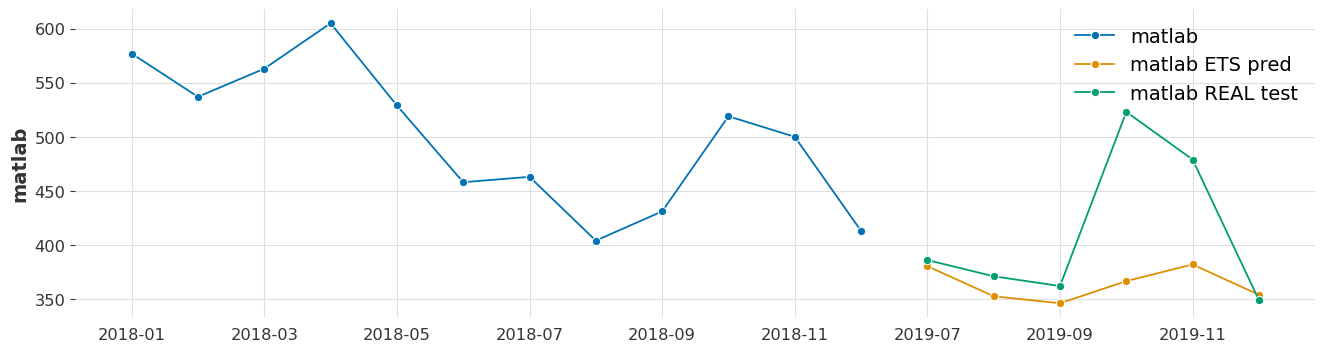

In [20]:
# Graficamos serie y predicción.
plot_series(y_train['2018'],stack_autoets_pred_test ,y_test, labels=["matlab", "matlab ETS pred", "matlab REAL test"])

In [21]:

# Calculamos MAPE Y RMSE del modelos en nuestro frame.
model_comparation.loc['MAPE','ETS']=mean_absolute_percentage_error(y_test,stack_autoets_pred_test)

rmse=MeanSquaredError(square_root=True)
rmse_ets_test=rmse(y_test, stack_autoets_pred_test)
model_comparation.loc['RMSE','ETS']=  rmse_ets_test
model_comparation

,ETS
aic,1463.211016
aicc,1465.526805
bic,1494.410117
hqic,1475.886233
MAPE,0.104028
RMSE,75.877988


## MODELO ARIMA.
Dado que hemos determinados que es una serie NO ESTACIONARIA, aplicaremos transformación BoX- Cox, dejando que sea el transformador quien eliga el mejor lamda para realizarla.



In [22]:
# Instanciamos un tranformador boxcox y se lo aplicamos a toda las serie.
trans_boxcox = BoxCoxTransformer(method='guerrero',sp=2)
boxcox_stack_ts= trans_boxcox.fit_transform(stack_df)

boxcox_stack_ts.tail()

,matlab
month,
2019-08-01,12.994701
2019-09-01,12.894351
2019-10-01,14.461157
2019-11-01,14.074342
2019-12-01,12.745993


Text(0.5, 1.0, 'consultas matlab: Transformación boxcox')

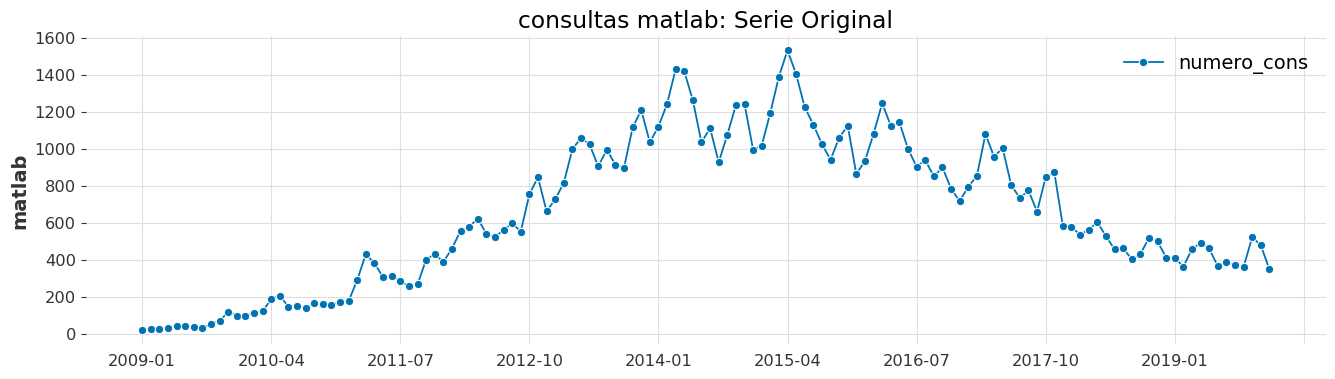

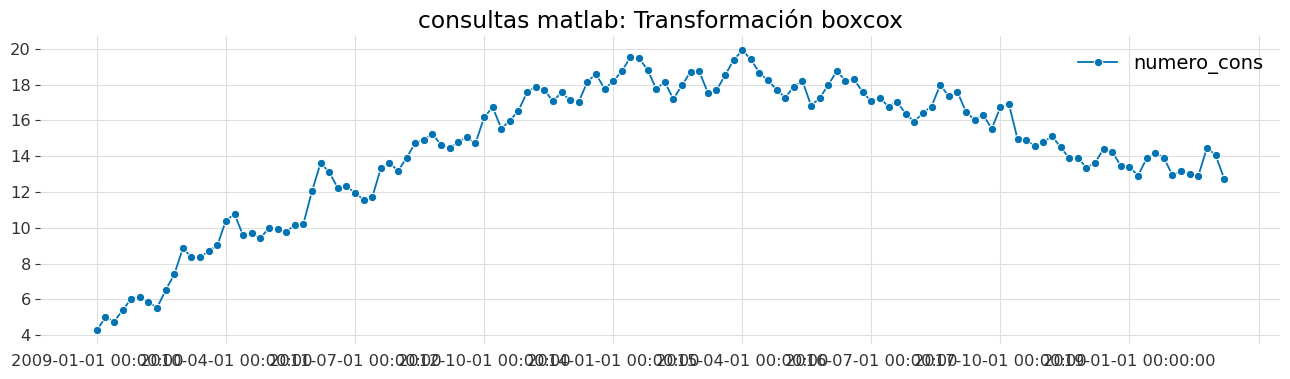

In [23]:
# Graficamos comparado la serie original y transformada.
fig, ax =plot_series(stack_ts_m, labels=["numero_cons"])
ax.set_title('consultas matlab: Serie Original')

fig, ax =plot_series(boxcox_stack_ts, labels=["numero_cons"])
ax.set_title('consultas matlab: Transformación boxcox')

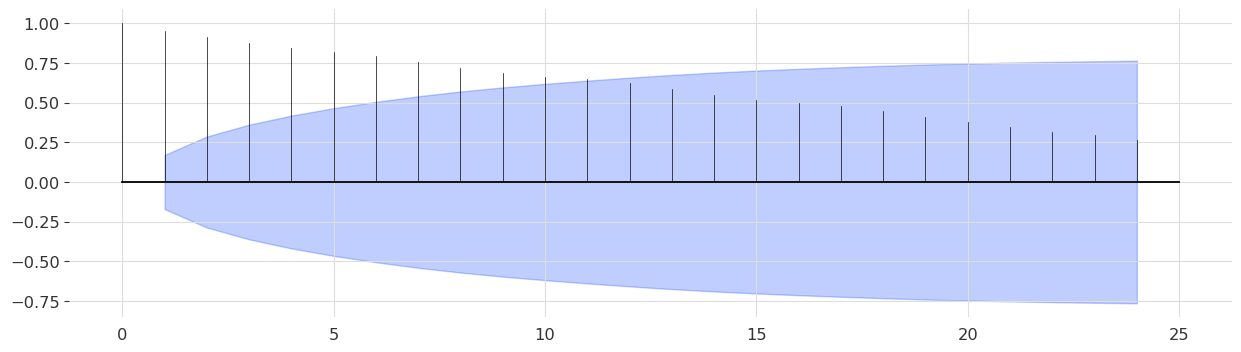

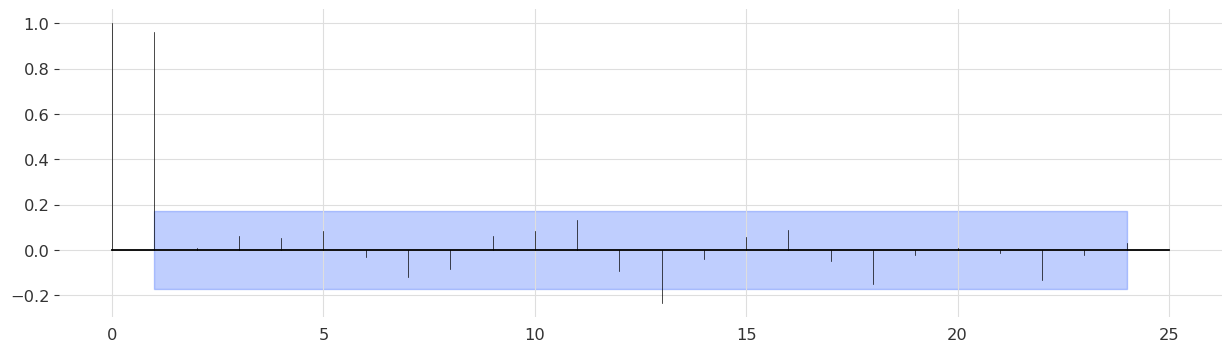

In [24]:

diff_0=boxcox_stack_ts.reset_index().rename(columns={"index": "month", 0: "matlab"})
diff_0= TimeSeries.from_dataframe(diff_0,'month','matlab')

plot_acf(diff_0,alpha=0.05,fig_size=(15,4))

plot_pacf(diff_0,alpha=0.05,fig_size=(15,4))


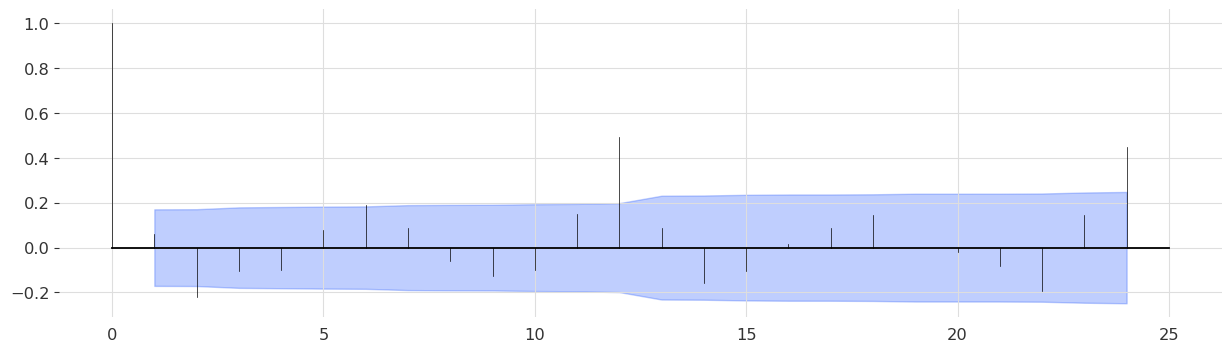

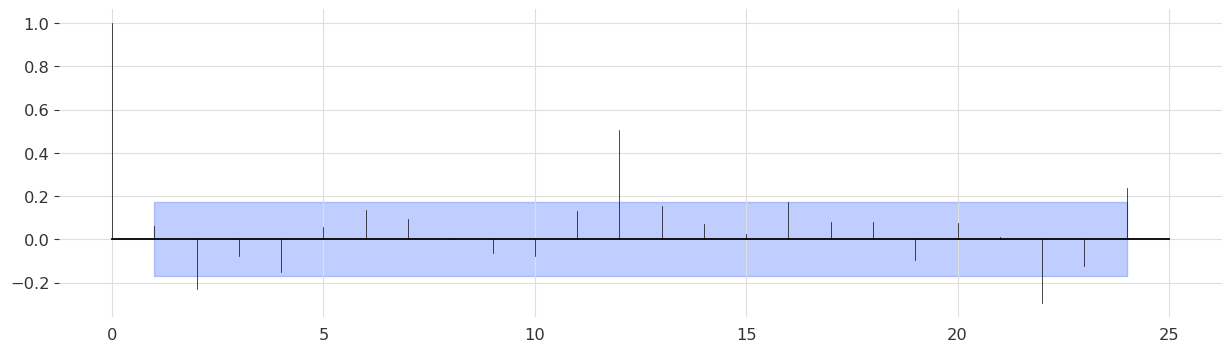

In [25]:
trans_diff= Differencer(lags=[1])
diff_1=trans_diff.fit_transform(boxcox_stack_ts).reset_index().rename(columns={"index": "month", 0: "matlab"})
diff_1= TimeSeries.from_dataframe(diff_1,'month','matlab')

plot_acf(diff_1,alpha=0.05,fig_size=(15,4))
plot_pacf(diff_1,alpha=0.05,fig_size=(15,4))

126 6
126 6


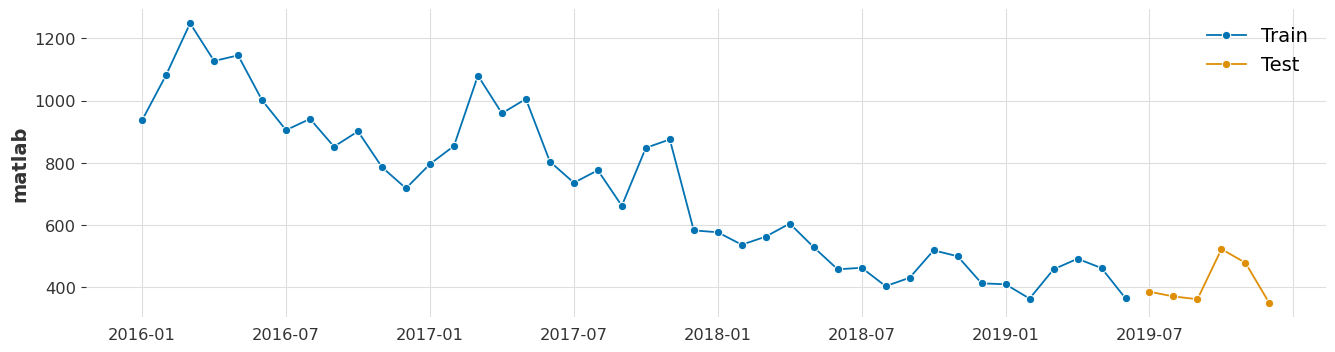

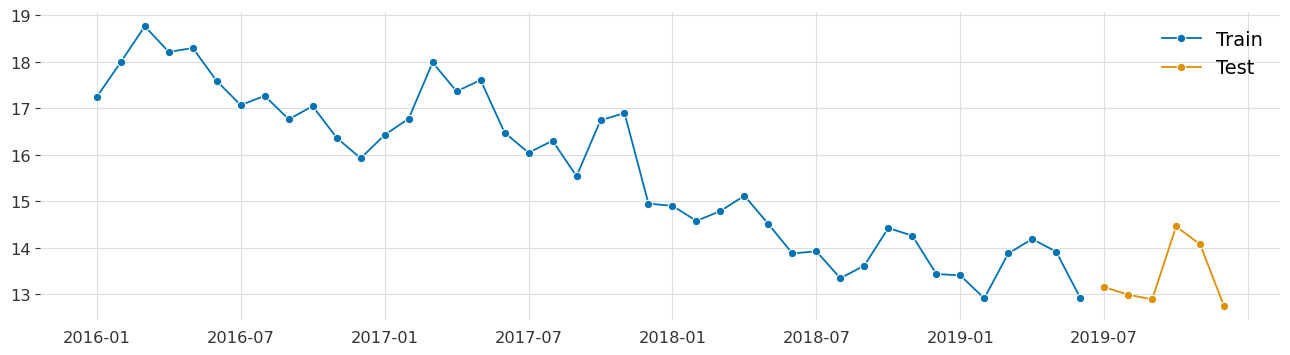

In [26]:
# Seleccionamos train y test. Para serie original y transformada por boxcox.
# Revisamos forma y graficamos.
y_train, y_test = temporal_train_test_split(y =stack_ts_m, test_size=6)
boxcox_stack_ts = boxcox_stack_ts.astype('float64').to_period('m').sort_index()
boxcox_y_train, boxcox_y_test = temporal_train_test_split(y =boxcox_stack_ts, test_size=6)

y_train_test=stack_ts_m
box_cox_y_train_test=boxcox_stack_ts

plot_series(y_train['2016':], y_test, labels=["Train", "Test"])
plot_series(boxcox_y_train['2016':],boxcox_y_test, labels=["Train", "Test"])


print(y_train.shape[0], y_test.shape[0])
print(boxcox_y_train.shape[0], boxcox_y_test.shape[0])

In [27]:
# Creamos y entrenamos un modelo AutoArima con los datos de entramiento transformados.
# Despues de probar con trimestre y semestre, el modelo Arima ajusta mejor suponiendo ciclos semestrales.
stack_arima_train = AutoARIMA(sp=2,suppress_warnings=True)
stack_arima_train.fit(boxcox_y_train)

AutoARIMA(sp=2, suppress_warnings=True)

In [28]:
#  Auto ARIMA Model Summary
print(stack_arima_train.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  126
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 2)   Log Likelihood                -122.385
Date:                                Tue, 22 Nov 2022   AIC                            254.769
Time:                                        11:13:26   BIC                            268.830
Sample:                                    01-31-2009   HQIC                           260.481
                                         - 06-30-2019                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L2        0.2231      0.169      1.319      0.187      -0.108       0.555
ar.

El modelo encontrado es un modelo SARIMAX, con parámetros:

Orden del Modelo Autoregresivo. P = 0

Número de diferenciaciones aplicadas a la serie original. d = 1

Orden del modelo de media movil (MA). q = 0

Orden del Modelo Autoregresivo Estacional. P = 2

Número de diferenciaciones aplicadas a la serie original de manera Estacional. D = 1

Orden del modelo media movil estacional. Q = 2

Número de pasos de tiempo que mide la estación de la serie. S = 0

In [29]:
# Alamcenmos los datos de ajuste de Arima en nuestro frame de comparación.
model_comparation.loc[['aic','aicc','bic','hqic'],
                      'ARIMA'] =  [stack_arima_train.get_fitted_params()[x] 
                                        for x in ['aic','aicc','bic','hqic']]

In [30]:
#  Predecimos con el fh de test.
boxcox_arima_pred_test = stack_arima_train.predict(fh_test)


In [31]:
# Transformación inversa de las predicciones.
real_stack_pred_test=trans_boxcox.inverse_transform(boxcox_arima_pred_test)
real_stack_pred_test

,matlab
2019-07,345.406691
2019-08,332.621829
2019-09,336.909565
2019-10,322.796537
2019-11,331.499144
2019-12,308.196527


In [32]:
# Transformamos las predicciones en TimeSerie de Darks para gráfico final
arima_bats= real_stack_pred_test
arima_bats.index=arima_bats.index.astype("datetime64[ns]") 
arima_bats=arima_bats.reset_index()
arima_bats=TimeSeries.from_dataframe(arima_bats,'index' ,'matlab')

In [33]:
# Calculamos el MAPE y RMSE de la predicción sin boxcox, alamcenamos en comparador.
model_comparation.loc['MAPE','ARIMA']= mean_absolute_percentage_error(y_test, real_stack_pred_test)
model_comparation.loc['RMSE','ARIMA']=rmse(y_test, real_stack_pred_test)

In [34]:
model_comparation

,ETS,ARIMA
aic,1463.211016,254.769144
aicc,1465.526805,255.281965
bic,1494.410117,268.830066
hqic,1475.886233,260.480655
MAPE,0.104028,0.180928
RMSE,75.877988,105.871843


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='matlab'>)

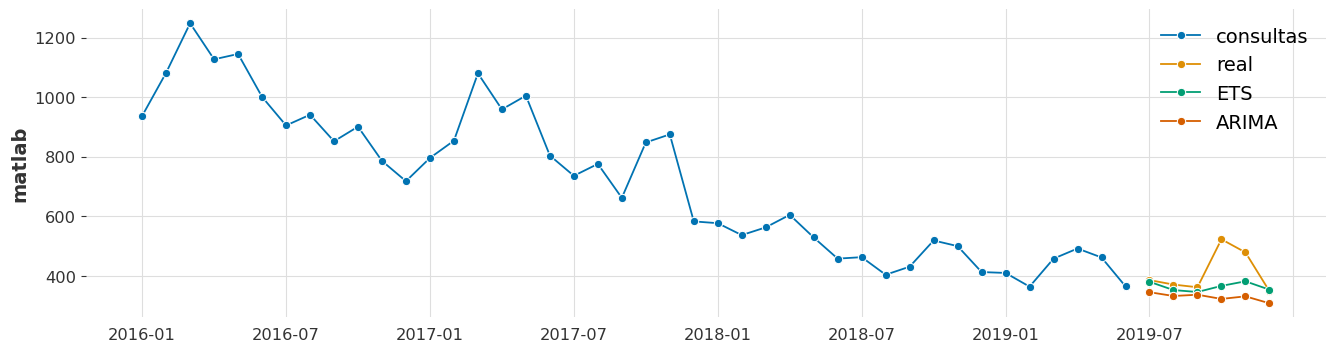

In [35]:
# Grafimamos serie y predicciones.
plot_series(y_train["2016":],y_test,stack_autoets_pred_test,real_stack_pred_test.to_period('M'),
            labels=["consultas","real","ETS", "ARIMA"])

### Adaptación de series para paquete Darts.
Darts tiene una clase específica para manejar las series temporales. A diferecia de sktime, no admite objetos de Pandas. Permite la adaptación de manera sencilla, pero hay que ser cuidadoso de como están construidos los indices en pandas, con freq establecida  y sin ningun hueco.

In [36]:
#Generamos un objeto TimeSeries de darts para poder usar sus funcionalidades.
stack_darts = TimeSeries.from_dataframe(stack_df.reset_index(), 'month', 'matlab')

In [37]:
# Divisimos en train, validation:12, test:6.
train,validation,test = stack_darts[:-18], stack_darts[-18:-6], stack_darts[-6:]

In [38]:
# Generamso una serie que englobe train y validation para poder predecir test con todos los datos anteiores.
train_validation=stack_darts[:-6]

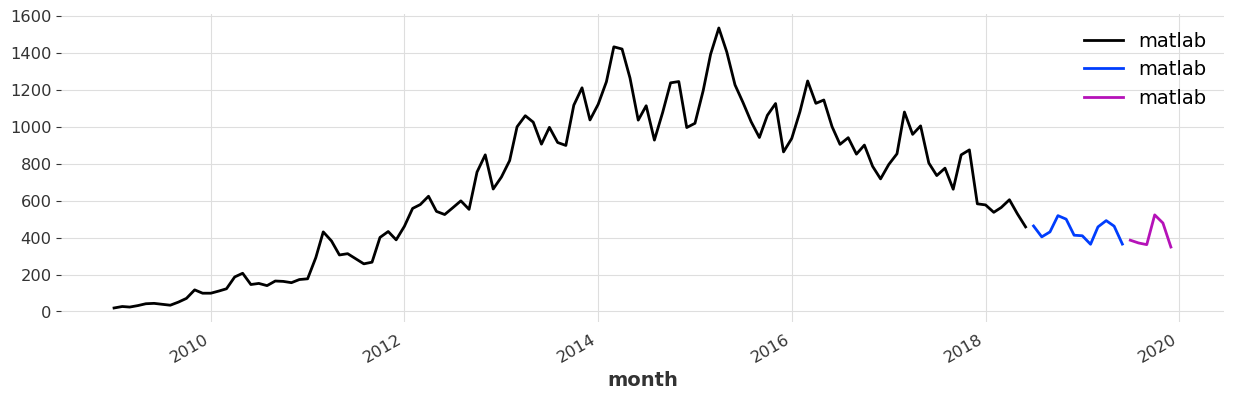

In [39]:
plt.figure(figsize=(15, 4))
train.plot()
validation.plot()
test.plot()

### Módelo 4Theta.
El modelo Theta de Assimakopoulos & Nikolopoulos (2000) es un método simple para pronosticar que consiste en dos líneas θ, pronosticar las líneas usando un suavizado exponencial simple y luego combinar los pronósticos de las dos líneas para producir el pronóstico final. 
El modelo se implementa en pasos: 
* Prueba de estacionalidad Desestacionalizar si se detecta estacionalidad.
* Estimar α ajustando un modelo SES a los datos y b0 por OLS. 
* Pronosticar la serie. 
* Reestacionalizar si los datos se desestacionalizaron.

Fuente: Documentación stats Python.

Los pasos que daremos será entrenar un modelos inicialm y realizar una busqueda en rejilla para que encuentre los parametros que mejor ajustan al modelo. Se le pasa como opciones de estacionalidad 3 y 6 meses.




In [40]:
# Generamos y entrenamo un modelo 4Theta con estacionalidad trimestral sobre trian
model =FourTheta(seasonality_period=3)
model.fit(train)
forecast = model.predict(len(validation))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(validation, forecast)))

model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 16.63%


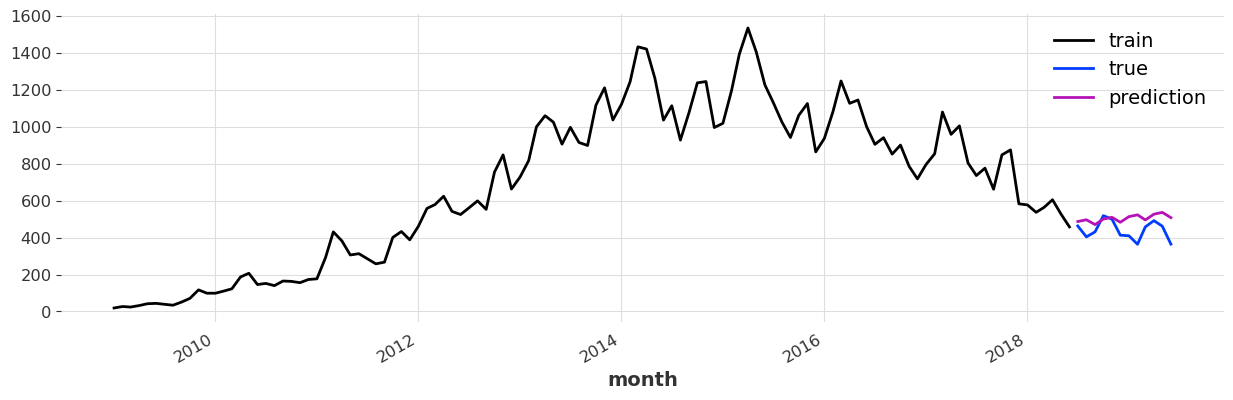

In [41]:
plt.figure(figsize=(15, 4))
train.plot(label="train")
validation.plot(label="true")
forecast.plot(label="prediction")

In [42]:
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
# Hacemos un busqueda en rejilla para encontrar el mejor ajuste con lso datos de train.
theta_grid = {
    'seasonality_period': [3,6],
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
    }

best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=train,
                                forecast_horizon=12, # 12
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

(<darts.models.forecasting.theta.FourTheta at 0x21b6a14f220>,
 {'seasonality_period': 6,
  'theta': 1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 17.457372989192066)

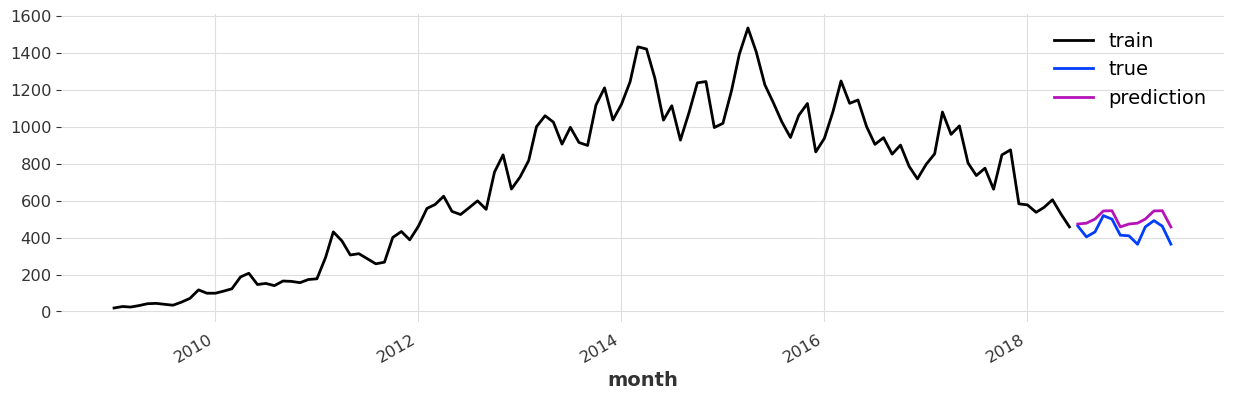

In [43]:
# El mejor modelo se guardar en best_grid_modelo[0]
plt.rcParams["figure.figsize"] = (15,4)

best_grid_model[0].fit(train)
pred_modelo_best = best_grid_model[0].predict(len(validation))
train.plot(label="train")
validation.plot(label="true")
pred_modelo_best.plot(label="prediction")

In [44]:
# Predecimos rest con todo train_vlidation. COmaprable con las estimaciones de los otros modelos.

theta_def=best_grid_model[0]
theta_def.fit(train_validation)
pred_theta_def = theta_def.predict(len(test))
pred_theta_def_p=pred_theta_def.pd_dataframe(copy=True).astype('float64').to_period('m').sort_index()

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='matlab'>)

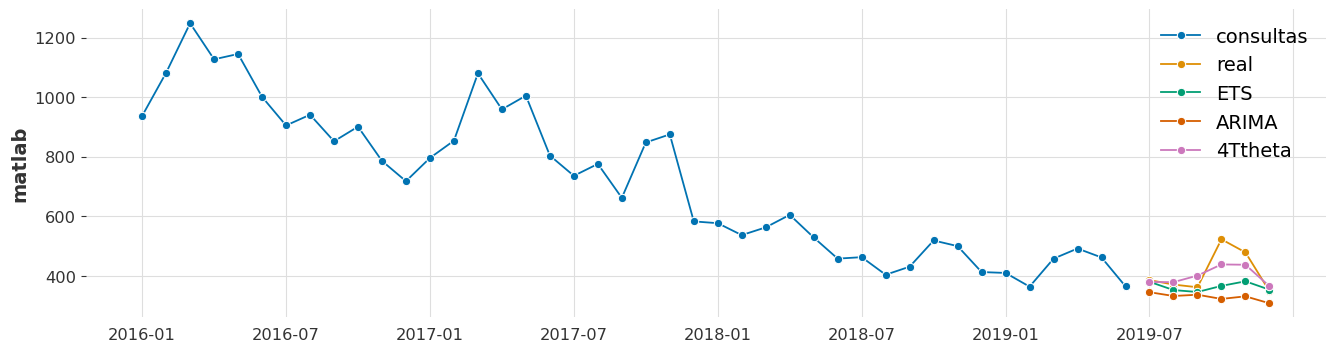

In [45]:
# Grafimamos serie y predicciones.
plot_series(y_train["2016":],y_test,stack_autoets_pred_test,real_stack_pred_test.to_period('M'),pred_theta_def_p,
            labels=["consultas","real","ETS", "ARIMA",'4Ttheta'])

In [46]:
model_comparation.loc['MAPE','4Theta']= best_grid_model[-1]
model_comparation.loc['RMSE','4Theta']= darts.metrics.rmse(pred_theta_def,test)

In [47]:
theta_def.model.params

{'smoothing_level': 0.9768907124573352,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.03046305949185901,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Modelo TBATS.
TBATS , que es un acrónimo de:

* Estacionalidad trigonométrica
* Transformación de Box- Cox
* ARMA errors
* Tendencia
* Componentes estacionales.
Este método se adapta a una variedad de modelos con y sin : estacionalidad,
transformación de Box-Cox, proceso ARMA(p, q), varias tendencias y
varios efectos estacionales.
Este método elegirá el modelo con el valor más bajo para el valor del criterio de información de Akaike (AIC) como modelo final.

Nos aprovechamos de la capcidad de Tbats de Darts de selecioanr los parametros que bajan el AIC. Solo le pasamos el parametro de estacionalidad, ya que os maneja muy bien, le damos estacionalidad, semestral, trimestral y cuatrimestral.

In [48]:
# Instanciamos un objeto TBATS dejando casó todos los parametros para que lso optimice para bajar AIC. Opción: None.
model =TBATS(
use_box_cox=None,
box_cox_bounds=(-2, 2),
use_trend=None,
use_damped_trend=None,
seasonal_periods=[3.0, 4.0, 6.0],
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)


model.fit(train_validation)


In [49]:
forecast = model.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(test, forecast)))

model (T)BATS obtains MAPE: 4.99%


In [50]:
print(model.model.params.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [3. 4. 6.]
Seasonal harmonics [1 1 1]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.411094
Smoothing (Alpha): 0.936662
Trend (Beta): -0.030676
Damping Parameter (Phi): 0.977992
Seasonal Parameters (Gamma): [ 1.29558826e-08 -2.00520163e-07 -6.71999458e-08  7.96888837e-08
  4.29644624e-08 -1.06363881e-07]
AR coefficients []
MA coefficients []
Seed vector [ 4.52270195  0.78877511  0.27260528  0.45662942 -0.64002503  0.24039394
 -1.48075611 -0.19701129]



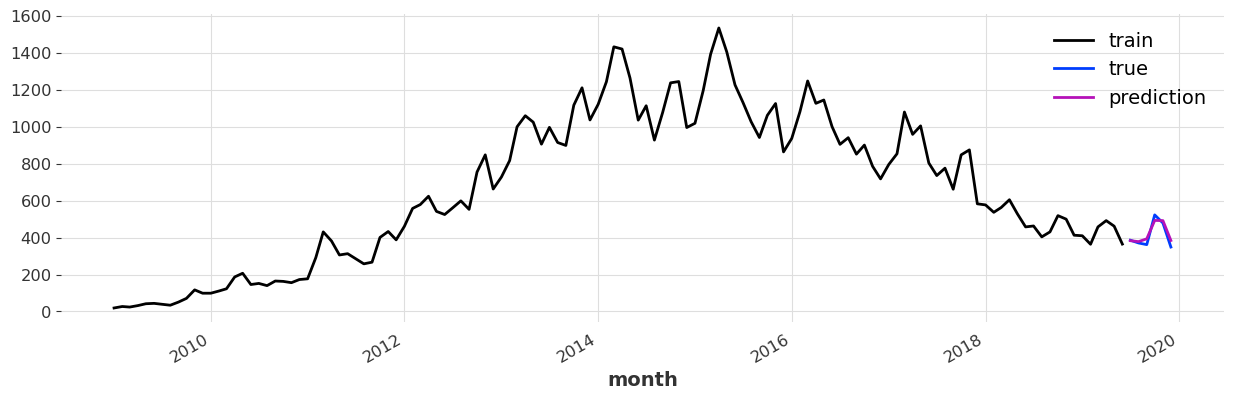

In [51]:
plt.rcParams["figure.figsize"] = (15,4)
train_validation.plot(label="train")
test.plot(label="true")
forecast.plot(label="prediction")

In [52]:
pred_bats_def_p=forecast.pd_dataframe(copy=True).astype('float64').to_period('m').sort_index()

In [53]:

model_comparation.loc['MAPE','TBATS']= mape(test, forecast)
model_comparation.loc['RMSE','TBATS']= darts.metrics.rmse(test, forecast)

## Resumen resultados y elección de modelo para predicción.

Como era de esperar el mejor modelo es TBATS, apto para trabajar con tendencias y estacionalidades complejas. Tiene un MAPE de 5 y un RMSE de 23.73.

En el gráfico se observa como es capaz de ajustar la estacionalidad dentro del segundo semestre de 2.019 con mucha precisión.


In [54]:
model_comparation.loc[['MAPE','RMSE'],:]

,ETS,ARIMA,4Theta,TBATS
MAPE,0.104028,0.180928,17.457373,4.992523
RMSE,75.877988,105.871843,42.344983,23.732960


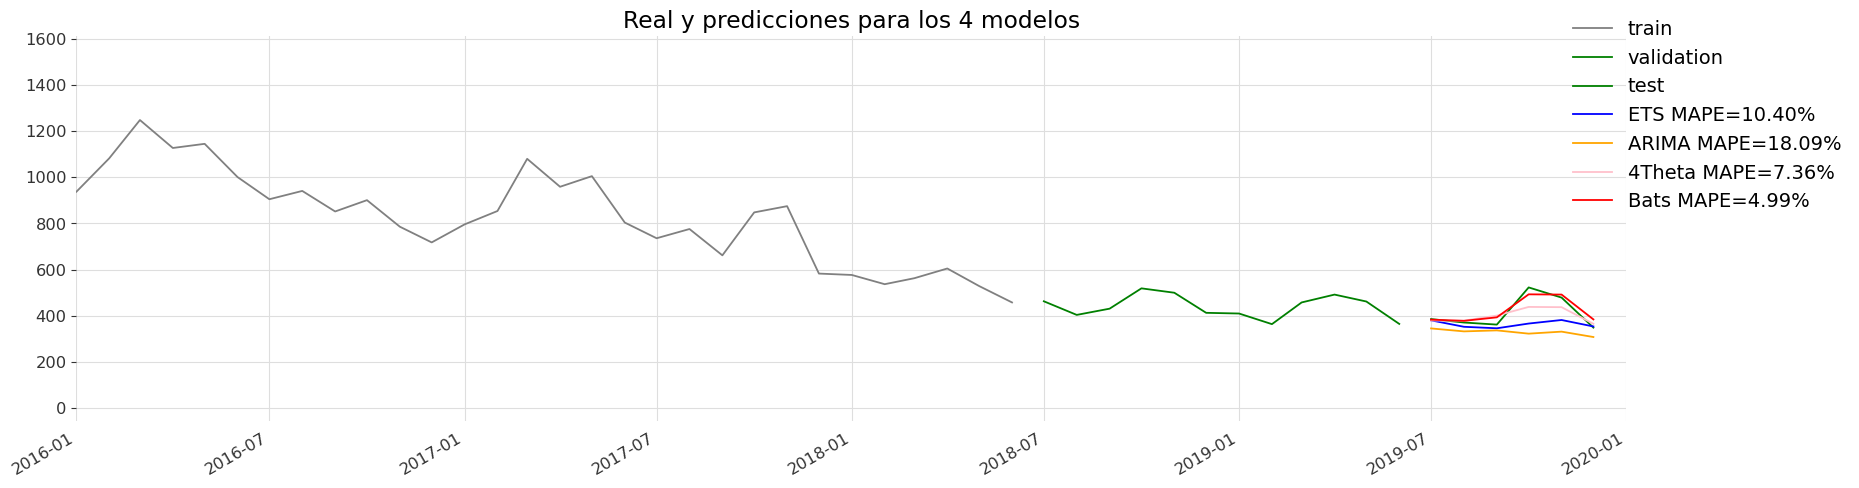

In [55]:

fechas_inicio_graf=datetime.strptime('2016/01/01', '%Y/%m/%d')
fechas_final_graf=datetime.strptime('2020/01/01', '%Y/%m/%d')

plt.rcParams["figure.figsize"] = (20,5)
train.plot(label='train', color='grey' , lw=1.3)
validation.plot(label='validation', color='green' , lw=1.3)
test.plot(label='test', color='green' , lw=1.3)
autoets_bats.plot(color='blue' , lw=1.3, label='ETS MAPE={:.2f}%'.format(mape(test, autoets_bats )))
arima_bats.plot(color='orange' , lw=1.3, label='ARIMA MAPE={:.2f}%'.format(mape(test, arima_bats )))
pred_theta_def.plot(color='pink' , lw=1.3, label='4Theta MAPE={:.2f}%'.format(mape(test,pred_theta_def )))
forecast.plot(color='red' , lw=1.3, label='Bats MAPE={:.2f}%'.format(mape(test,forecast )))

plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0.5))
plt.title('Real y predicciones para los 4 modelos')
plt.xlim(fechas_inicio_graf,fechas_final_graf)
plt.xlabel('')
display()

## PREDICCIÓN PARA EL AÑO 2.020.
Ajustamos el modelo elegido, TBATS para que nso prediga 12 periodos y graaficamos. 
Ejercicio terminado con bastante recurso a Stackoverflow, que hariamos sin él.

In [56]:
# ajustamos el modelo con todos los datos disponibles de la serie, y generamso predicción para 12 meses.

model.fit(stack_darts )

forecast_2020 = model.predict(12)

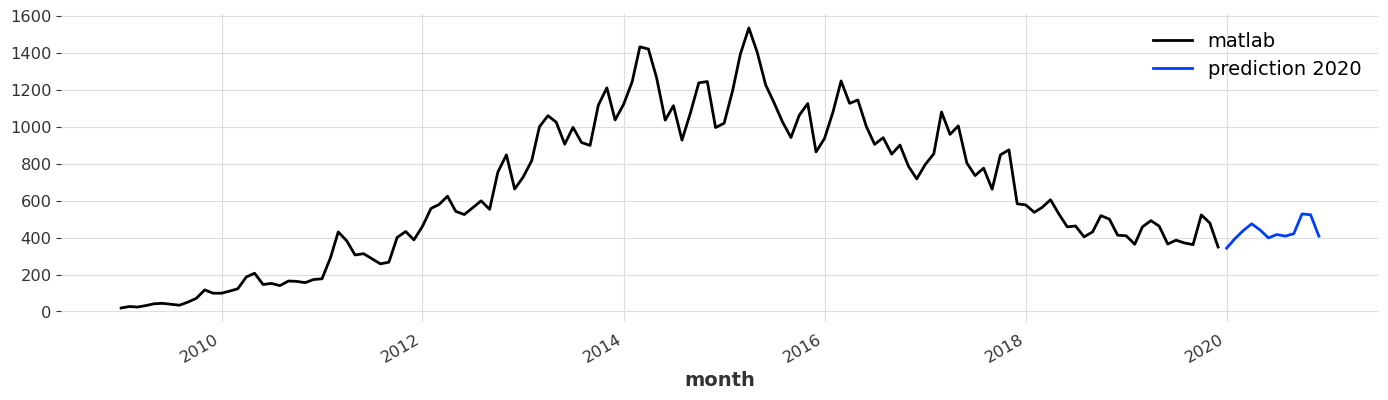

In [57]:
plt.rcParams["figure.figsize"] = (17,4)
stack_darts.plot(label="matlab")

forecast_2020.plot(label="prediction 2020")